Solve the following system of differential equations:
 x1' = x3 + x2, 
 x2' = x4 - x1, 
 x3' = x4 - x1, 
 x4' = -(x2 + x3), 
 x1(0) = 1, 
 x2(0) = 1, 
 x3(0) = 1, 
 x4(0) = 1
 
Procedure: Assume solution of the form 1 + t * N for all.
Error function to minimise is basically the same.

In [8]:
from autograd import grad
import autograd.numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

# The RHS of the differential equation 
def dx_dt(x):
    x = np.transpose(x)
    return np.transpose(np.array([x[2] + x[1], x[3] - x[0], x[3] - x[0], -1 * (x[2] + x[1])]))

# HP1 : Hyperparameter 1, the no. of intervals to break the interval into.
# We require the solution of the differential equation in the interval only.
batch_size = 250

# Returns batch_size no of points disributed uniformly over the interval
def get_data():
    t = np.linspace(-0.5,0.5,num=batch_size, endpoint=True)
    t.shape = (1, batch_size)
    return t

In [10]:
def init_random_params(scale, layer_sizes, rs=np.random.RandomState(0)):
    return [(scale * rs.randn(n, m),   # weight matrix
             scale * rs.randn(n, 1))      # bias vector
            for m, n in zip(layer_sizes[:-1], layer_sizes[1:])]

In [13]:
def sigmoid(x):
    return 1/(1 + np.exp(-x))

# Return the softplus of variable x
def softplus(x):
    return np.log(1 + np.exp(x))

def relu(x):
    return np.maximum(0, x)

# Choose activation
#activation = softplus
activation = relu
# Forward propagation
def neural_net_predict1(params, inputs):
    """Implements a deep neural network for classification.
       params is a list of (weights, bias) tuples.
       inputs is an (N x D) matrix.
       returns normalized class log-probabilities."""
    for W, b in params:
        outputs = np.dot(W, inputs) + b
        inputs = activation(outputs)
    return outputs

# To facilitate computation of gradient with respect to input
def neural_net_predict2(inputs, params):
    return neural_net_predict1(params, inputs)

def neural_net_predict3(params, inputs):
    y = []
    for W, b in params:
        print(inputs.shape, W.shape, b.shape)
        y.append(inputs)
        outputs = np.dot(W, inputs) + b
        inputs = activation(outputs)
    y.append(outputs)
    return y

In [23]:
grad(neural_net_predict2)(t, init_params).shape

(1, 250)

In [28]:
neural_net_predict1(init_params, t).shape

(4, 250)

In [26]:
cost(init_params, 0)

ValueError: operands could not be broadcast together with shapes (4,4) (4,250) 

In [14]:
param_scale = 0.01
num_epochs = 4401
step_size = 0.01
layer_sizes = [1, 4, 16, 16, 4]
init_params = init_random_params(param_scale, layer_sizes)
from autograd.optimizers import adam
t = get_data()
def cost(params, iter):
    N = neural_net_predict1(params, t)
    c = np.mean((dx_dt(1 + N * t) - N 
                 - grad(neural_net_predict2)(t, params) * t)**2)
    if iter % 200 == 0:
        print('Train cost  ' + str(c))
    return c

objective_grad = grad(cost)
# The optimizers provided can optimize lists, tuples, or dicts of parameters.
optimized_params = adam(objective_grad, init_params, step_size=step_size,
                            num_iters=num_epochs)

ValueError: operands could not be broadcast together with shapes (4,4) (4,250) 

In [71]:
N = neural_net_predict1(optimized_params, cv_t)
print('Test cost ' +
            str(np.mean((dx_dt(1 + N*cv_t) - N
                         - grad(neural_net_predict2)(cv_t, optimized_params)*cv_t)**2)))

Test cost 0.00486010164259


In [72]:
test = np.reshape(np.sort(np.squeeze(get_data())), (batch_size,1))
t = np.squeeze(test)
analytic_solution = np.array([1 + np.sin(2*t), np.cos(2*t), np.cos(2*t), 1 - np.sin(2*t)])
analytic_solution.shape

(4, 250)

In [73]:
found_solution = np.transpose(1 + neural_net_predict1(optimized_params, test) * test)
found_solution.shape

(4, 250)

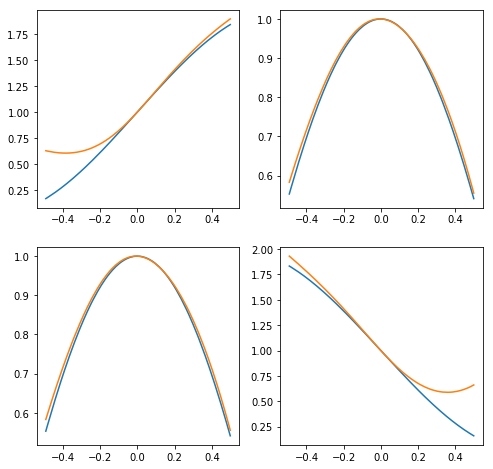

In [74]:
plt.figure(figsize=(8,8))
plt.subplot(221)
plt.plot(t, analytic_solution[0], t, found_solution[0])
plt.subplot(222)
plt.plot(t, analytic_solution[1], t, found_solution[1])
plt.subplot(223)
plt.plot(t, analytic_solution[2], t, found_solution[2])
plt.subplot(224)
plt.plot(t, analytic_solution[3], t, found_solution[3])

In [75]:
grad_analytic_solution = np.array([2 * np.cos(2*t), -2 * np.sin(2*t), -2 * np.sin(2*t), - 2 * np.cos(2*t)])
print(grad_analytic_solution.shape)
N = neural_net_predict1(optimized_params, test)
grad_found_solution = np.transpose(N + grad(neural_net_predict2)(test, optimized_params) * test)
print(grad_found_solution.shape)

(4, 250)
(4, 250)


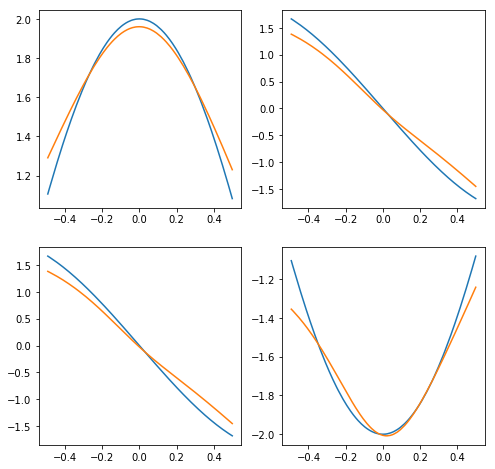

In [76]:
plt.figure(figsize=(8,8))
plt.subplot(221)
plt.plot(t, grad_analytic_solution[0], t, grad_found_solution[0])
plt.subplot(222)
plt.plot(t, grad_analytic_solution[1], t, grad_found_solution[1])
plt.subplot(223)
plt.plot(t, grad_analytic_solution[2], t, grad_found_solution[2])
plt.subplot(224)
plt.plot(t, grad_analytic_solution[3], t, grad_found_solution[3])

In [77]:
analyse_t = np.reshape(np.array([-0.4, -0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3, 0.4]), (9, 1))
layerwise_solution = neural_net_predict3(optimized_params, analyse_t)
layerwise_solution

(9, 1) (1, 4) (4,)
(9, 4) (4, 16) (16,)
(9, 16) (16, 16) (16,)
(9, 16) (16, 4) (4,)


[array([[-0.4],
        [-0.3],
        [-0.2],
        [-0.1],
        [ 0. ],
        [ 0.1],
        [ 0.2],
        [ 0.3],
        [ 0.4]]), array([[ 0.68084133,  0.67285574,  0.67575083,  0.69815612],
        [ 0.77949252,  0.76927737,  0.77126716,  0.79134098],
        [ 0.88714929,  0.87446322,  0.87534179,  0.8923331 ],
        [ 1.00359268,  0.98821916,  0.98778534,  1.0009452 ],
        [ 1.1284603 ,  1.11021351,  1.10827731,  1.11688238],
        [ 1.26127027,  1.23999846,  1.2363863 ,  1.2397591 ],
        [ 1.40145058,  1.37703698,  1.37159536,  1.36911967],
        [ 1.54837054,  1.52073198,  1.51332949,  1.50446046],
        [ 1.701371  ,  1.67045483,  1.66098259,  1.64525144]]), array([[ 1.06578982,  1.6773373 ,  1.66395023,  1.09819018,  1.21698065,
          1.52677092,  1.28522259,  1.69461124,  1.22717653,  1.72886245,
          1.67324884,  1.73895681,  1.57396624,  1.09980051,  1.64552371,
          1.68513852],
        [ 1.0679951 ,  1.86974111,  1.89066643,  1.

In [109]:
layer = layerwise_solution[2]
#print(layer)
assert len(layer) == 9
var = [np.var(layer[i], ddof=1) for i in range(len(layer))]
var

[0.066548249046736743,
 0.12418690165046201,
 0.21251430059778217,
 0.34016647514825255,
 0.51615864401663047,
 0.7493967907460698,
 1.0482544476825142,
 1.4202752405685941,
 1.8720154314797546]

In [29]:
optimized_params

[(array([[-1.5258114 , -1.50907477, -1.51169493, -1.51571156]]),
  array([ 1.16402244,  1.14232773,  1.14793632,  1.15187059])),
 (array([[ 0.84063496,  0.81524914,  0.8135664 ,  0.81212417,  0.78953735,
           0.80472435],
         [ 0.81692358,  0.79790232,  0.81642051,  0.80718959,  0.78082128,
           0.80055861],
         [ 0.83268223,  0.81826102,  0.82035084,  0.79420806,  0.79923011,
           0.80002511],
         [ 0.82548329,  0.81966967,  0.80302633,  0.80957493,  0.78922482,
           0.80037857]]),
  array([-0.16808397, -0.14020879, -0.15759346, -0.15787779, -0.13999822,
         -0.15196005])),
 (array([[ 0.27215226,  0.26739403,  0.29979644,  0.32206239,  0.26194991,
           0.24416125,  0.32268312,  0.25890294],
         [ 0.26730239,  0.26166449,  0.25387937,  0.29427028,  0.24535202,
           0.2437003 ,  0.30492119,  0.24136015],
         [ 0.26946257,  0.28162232,  0.26715731,  0.3177664 ,  0.24304155,
           0.23771658,  0.30008111,  0.24600227],

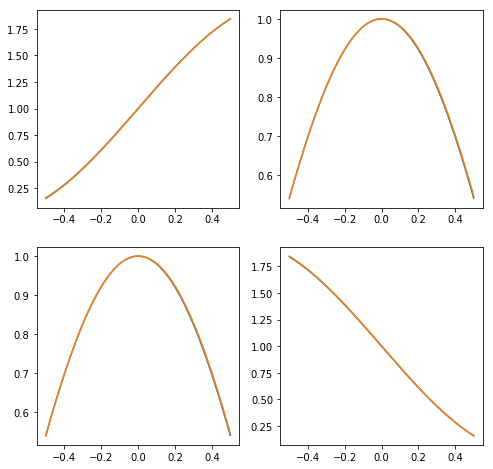

In [47]:
def estimate():
    t = np.linspace(-0.5, 0.5, num=batch_size)
    x = [np.zeros(4) for _ in range(batch_size)]
    for j in range(4):
        x[batch_size//2][j] = 1
    for i in range(batch_size//2 + 1, batch_size):
        x[i] = x[i-1] + (t[i] - t[i-1]) * dx_dt(x[i-1])
    for i in range(batch_size//2 -1, -1, -1):
        x[i] = x[i+1] - (t[i+1] - t[i]) * dx_dt(x[i+1])
    x = np.transpose(np.array(x))
    analytic_solution = np.array([1 + np.sin(2*t), np.cos(2*t), np.cos(2*t), 1 - np.sin(2*t)])
    plt.figure(figsize=(8,8))
    plt.subplot(221)
    plt.plot(t, analytic_solution[0], t, x[0])
    plt.subplot(222)
    plt.plot(t, analytic_solution[1], t, x[1])
    plt.subplot(223)
    plt.plot(t, analytic_solution[2], t, x[2])
    plt.subplot(224)
    plt.plot(t, analytic_solution[3], t, x[3])
estimate()